In [1]:
import refitter as rf
reload(rf)

import ROOT as RT
# RT.gROOT.LoadMacro("~/rootlogon.C")
RT.gStyle.SetOptStat(0)
RT.gStyle.SetPalette(RT.kViridis)
import numpy as np

import pyrapp as pya
reload(pya)
app = pya.PyRApp([],args=["-O","plots"])
app.options.saveas=["root","pdf"]
def save(obj):
    app.keep(obj,format=True)
    app.save(True)

#%jsroot on
%jsroot off

Welcome to JupyROOT 6.07/07
[Errno 17] File exists: 'plots'


In [20]:
inputDir="/eos/user/m/musella/data/mod_dep_004"

eff = rf.ProcessHistos("Eff",inputDir+"/output_InsideAcceptance_125.root",
                      "hpty",
                      "genPt:abs(genRapidity)","(100,0.,3,100,0,300)","abs(weight)",3,
                      doOverall=True
                     )


Eff
genPt:abs(genRapidity)>>hptyEff_0(100,0.,3,100,0,300)
genPt:abs(genRapidity)>>hptyEff_1(100,0.,3,100,0,300)
genPt:abs(genRapidity)>>hptyEff_2(100,0.,3,100,0,300)


Warning in <TCanvas::Constructor>: Deleting canvas with same name: efficiency
Info in <TCanvas::SaveAs>: ROOT file plots/efficiency.root has been created
Info in <TCanvas::Print>: pdf file plots/efficiency.pdf has been created


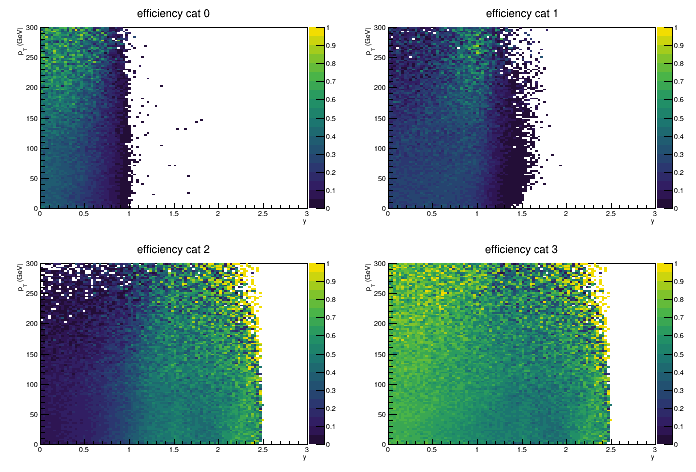

In [21]:
#%jsroot on
eff.computeEfficiencies()

canv=rf.drawHists(eff,htitle="efficiency cat %d; y;p_{T} (GeV)",nplots=-1,name="efficiency")
save(canv)

In [4]:
sm = rf.ProcessHistos("SM",inputDir+"/output_InsideAcceptance_125.root",
                      "hpty",
                      "genPt:abs(genRapidity)","(30,0.,3,30,0,300)","weight",3,
                     doOverall=True)

smoa = rf.ProcessHistos("SM_OA",inputDir+"/output_OutsideAcceptance_125.root",
                      "hpty",
                      "genPt:abs(genRapidity)","(30,0.,3,30,0,300)","weight",3,
                      treepfx="genDiphotonDumper/trees/OutsideAcceptance_125_13TeV",  
                    )



SM
genPt:abs(genRapidity)>>hptySM_0(30,0.,3,30,0,300)
genPt:abs(genRapidity)>>hptySM_1(30,0.,3,30,0,300)
genPt:abs(genRapidity)>>hptySM_2(30,0.,3,30,0,300)

SM_OA
genPt:abs(genRapidity)>>hptySM_OA_0(30,0.,3,30,0,300)
genPt:abs(genRapidity)>>hptySM_OA_1(30,0.,3,30,0,300)
genPt:abs(genRapidity)>>hptySM_OA_2(30,0.,3,30,0,300)


In [5]:
num = sm.genHist.Clone("num")
den = sm.genHist.Clone("den")
den.Add(smoa.genHist)
num.Divide(num,den,1.,1.,"b")
acc=num

Info in <TCanvas::SaveAs>: ROOT file plots/acceptance.root has been created
Info in <TCanvas::Print>: pdf file plots/acceptance.pdf has been created
Info in <TCanvas::SaveAs>: ROOT file plots/acceptance1D.root has been created
Info in <TCanvas::Print>: pdf file plots/acceptance1D.pdf has been created


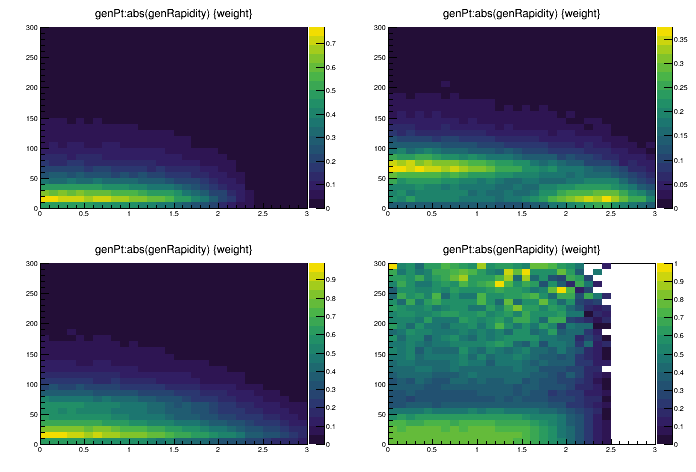

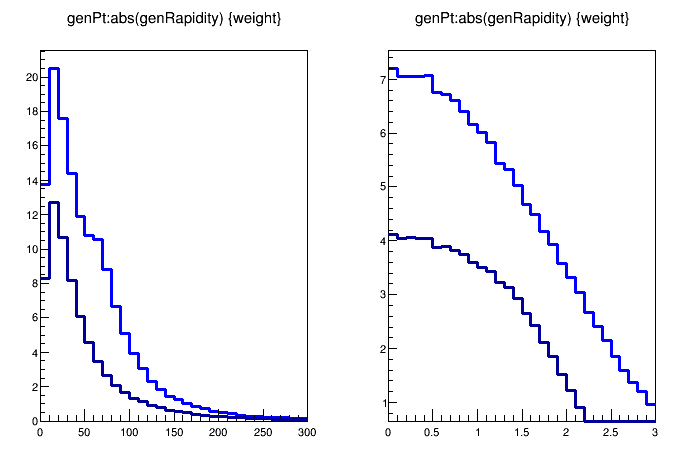

In [6]:
canv=RT.TCanvas("acceptance","acceptance")
canv.Divide(2,2)
canv.cd(1)
sm.genHist.Draw("colz")
canv.cd(2)
smoa.genHist.Draw("colz")
canv.cd(3)
den.Draw("colz")
canv.cd(4)
acc.GetZaxis().SetRangeUser(0.,1.)
acc.Draw("colz")
canv.Draw()

denpt=den.ProjectionY()
denpt.SetLineColor(RT.kRed)
fidpt=sm.genHist.ProjectionY()
denpt.SetLineColor(RT.kBlue)

deny=den.ProjectionX()
deny.SetLineColor(RT.kRed)
fidy=sm.genHist.ProjectionX()
deny.SetLineColor(RT.kBlue)

canv2=RT.TCanvas("acceptance1D","accepance1D")
canv2.Divide(2,1)
canv2.cd(1)
denpt.Draw("hist")
fidpt.Draw("hist same")
canv2.cd(2)
deny.Draw("hist")
fidy.Draw("hist same")

canv2.Draw()
save([canv,canv2])

In [7]:

meas = [[ 0.4800, +0.3792, -0.3265,],
        [ 0.7600, +0.32, -0.4451,],
        [ 1.1050, +0.578, -0.623,],]


data=rf.DataRecord( np.array(map(lambda x: x[0], meas )), 
                    np.array(map(lambda x: (x[1]+abs(x[2]))*0.5, meas )),
                    None
                     )

fitter = rf.Fitter(data,eff,sm)

In [8]:
fitter.fitModel(sm)

FitRecord(meas=0.6867387733290985, err=0.2381068978749498, effRatios=array([ 1.,  1.,  1.]), bias=1.0)

In [9]:
sm_procs = map(lambda x: rf.ProcessHistos(x,inputDir+"/output_InsideAcceptance_%s_125.root" %x,
                      "hpty",
                      "genPt:abs(genRapidity)","(30,0.,3,30,0,300)","weight",3,
                     ),  ["ggF","VBF","VH","ttH"] )


ggF
genPt:abs(genRapidity)>>hptyggF_0(30,0.,3,30,0,300)
genPt:abs(genRapidity)>>hptyggF_1(30,0.,3,30,0,300)
genPt:abs(genRapidity)>>hptyggF_2(30,0.,3,30,0,300)

VBF
genPt:abs(genRapidity)>>hptyVBF_0(30,0.,3,30,0,300)
genPt:abs(genRapidity)>>hptyVBF_1(30,0.,3,30,0,300)
genPt:abs(genRapidity)>>hptyVBF_2(30,0.,3,30,0,300)

VH
genPt:abs(genRapidity)>>hptyVH_0(30,0.,3,30,0,300)
genPt:abs(genRapidity)>>hptyVH_1(30,0.,3,30,0,300)
genPt:abs(genRapidity)>>hptyVH_2(30,0.,3,30,0,300)

ttH
genPt:abs(genRapidity)>>hptyttH_0(30,0.,3,30,0,300)
genPt:abs(genRapidity)>>hptyttH_1(30,0.,3,30,0,300)
genPt:abs(genRapidity)>>hptyttH_2(30,0.,3,30,0,300)


In [10]:
from pprint import pprint
pprint(map(fitter.fitModel,sm_procs))

[FitRecord(meas=0.68929736553868282, err=0.2388208718654943, effRatios=array([ 0.9938764 ,  0.99993552,  0.99885341]), bias=0.99700624727632425),
 FitRecord(meas=0.64105228007847381, err=0.22547943861825898, effRatios=array([ 1.09981868,  1.03233111,  0.98151205]), bias=1.0550729149135656),
 FitRecord(meas=0.71392760594437055, err=0.24549834268126167, effRatios=array([ 0.96114164,  0.93960663,  1.06401453]), bias=0.9689728779447726),
 FitRecord(meas=0.51938149998411198, err=0.19250734215764342, effRatios=array([ 1.40427112,  1.1586555 ,  0.84321058]), bias=1.2209058939732047)]


In [11]:
sm_ooa = map(lambda x: rf.ProcessHistos(x,inputDir+"/output_OutsideAcceptance_%s_125.root" %x,
                    "hpty",
                    "genPt:abs(genRapidity)","(30,0.,3,30,0,300)","weight",3,
                    treepfx="genDiphotonDumper/trees/OutsideAcceptance_125_13TeV"
                     ),  ["ggF","VBF","VH","ttH"] )




ggF
genPt:abs(genRapidity)>>hptyggF_0(30,0.,3,30,0,300)
genPt:abs(genRapidity)>>hptyggF_1(30,0.,3,30,0,300)
genPt:abs(genRapidity)>>hptyggF_2(30,0.,3,30,0,300)

VBF
genPt:abs(genRapidity)>>hptyVBF_0(30,0.,3,30,0,300)
genPt:abs(genRapidity)>>hptyVBF_1(30,0.,3,30,0,300)
genPt:abs(genRapidity)>>hptyVBF_2(30,0.,3,30,0,300)

VH
genPt:abs(genRapidity)>>hptyVH_0(30,0.,3,30,0,300)
genPt:abs(genRapidity)>>hptyVH_1(30,0.,3,30,0,300)
genPt:abs(genRapidity)>>hptyVH_2(30,0.,3,30,0,300)

ttH
genPt:abs(genRapidity)>>hptyttH_0(30,0.,3,30,0,300)
genPt:abs(genRapidity)>>hptyttH_1(30,0.,3,30,0,300)
genPt:abs(genRapidity)>>hptyttH_2(30,0.,3,30,0,300)


In [12]:
pprint(map(lambda x: map(lambda y: (y[0].GetName(),y[1].Integral()/y[0].Integral()), 
                  zip(x[0].hists,x[1].hists)) , zip(sm_procs,sm_ooa) ))

[[('hptyggF_0', 0.0022175541263323314),
  ('hptyggF_1', 0.004164697432260983),
  ('hptyggF_2', 0.01309083193371668)],
 [('hptyVBF_0', 0.003372682493853811),
  ('hptyVBF_1', 0.004264144230767664),
  ('hptyVBF_2', 0.014349748366641452)],
 [('hptyVH_0', 0.01555818721305878),
  ('hptyVH_1', 0.0161780972390254),
  ('hptyVH_2', 0.02754067067723247)],
 [('hptyttH_0', 0.057445279126564656),
  ('hptyttH_1', 0.04877665023632295),
  ('hptyttH_2', 0.059061610813843785)]]


In [13]:
sm_weights = np.array(map(lambda x: fitter.fitEfficiencies(x,True).bias, 
        [np.array([1.,0.,0.]), 
         np.array([0.,1.,0.]),
         np.array([0.,0.,1.])
        ]))

#sm_effs = np.array(sm.predictYields(eff,True)[:sm.ncats])

In [14]:
from copy import deepcopy
weights_map = deepcopy(eff)

weights_map.hists = weights_map.hists[:weights_map.ncats]
map(lambda x: x[0].Scale(x[1]*weights_map.ncats),zip(weights_map.hists,sm_weights))

weights_map.hists.append(rf.mergeHists(weights_map.hists[:weights_map.ncats]))

[ 0.45536926  0.38740707  0.15722367]


Info in <TCanvas::SaveAs>: ROOT file plots/weighted_eff.root has been created
Info in <TCanvas::Print>: pdf file plots/weighted_eff.pdf has been created


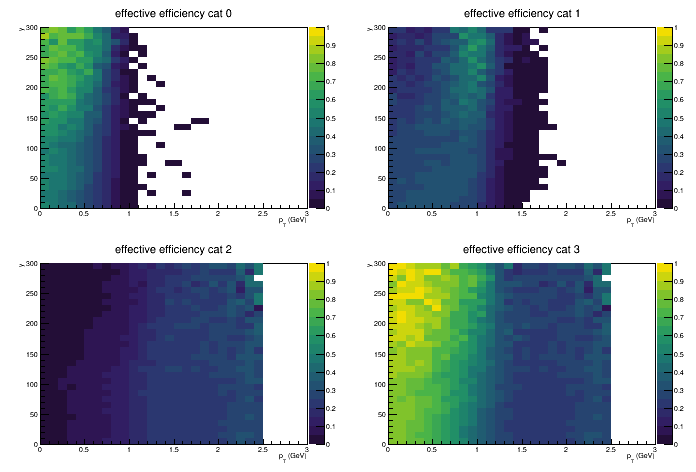

In [15]:
canv=rf.drawHists(weights_map,htitle="effective efficiency cat %d;p_{T} (GeV); y",nplots=-1,name="weighted_eff")
save(canv)
print(sm_weights)

In [16]:
fitter.refEffs.sum()

0.5831059684152855